# Regressão Linear

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
%matplotlib inline

plt.rcParams['figure.figsize']  = (16, 8)
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['lines.linewidth'] = 4

plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [2]:
# Importando dataset
dados = pd.read_excel("./datasets/dados_posGraduacao_UFMG.xlsx", index_col=0)

In [3]:
# Removendo entradas inferiores a 2008 e menores que 2018
dados08_17 = dados.query("AnoBase >= 2008")
dados08_17 = dados08_17.query("AnoBase < 2018")

# Removendo cursos sem nome
dados08_17 =  dados08_17[pd.notnull(dados08_17['NomePrograma'])]

print("Ano Max", dados08_17['AnoBase'].max(), "Ano Min:", dados08_17['AnoBase'].min())
display(dados08_17)

Ano Max 2017.0 Ano Min: 2008.0


,Chave,AnoBase,BolsasDoutorado,BolsasMestrado,CodigoPrograma,Dissertacao,NomePrograma,NotaCapesDoutorado,NotaCapesMestrado,ProducoesArtisticas,ProducoesBibliograficas,ProducoesTecnicas,NumTeses,ValorAnualBolsaDoutorado,ValorAnualBolsaMestrado
19,32001010051P42008,2008.0,2.0,9.0,32001010051p4,19.0,artes,5,5,126.0,162.0,237.0,1.0,43200.0,129600.0
20,32001010049P02008,2008.0,0.0,6.0,32001010049p0,13.0,arquitetura,4,4,10.0,100.0,163.0,0.0,0.0,86400.0
21,32001010056P62008,2008.0,12.0,16.0,32001010056p6,42.0,estudos literários,7,7,13.0,415.0,447.0,24.0,259200.0,230400.0
22,32001010051P42009,2009.0,2.0,12.0,32001010051p4,25.0,artes,5,5,164.0,197.0,235.0,0.0,43200.0,172800.0
23,32001010051P42010,2010.0,4.0,21.0,32001010051p4,31.0,artes,5,5,146.0,125.0,157.0,6.0,86400.0,302400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,33002010200P92008,2008.0,1.0,0.0,33002010200p9,0.0,artes cênicas,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1900,33002029017P52008,2008.0,1.0,0.0,33002029017p5,0.0,enfermagem fundamental,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1901,33010013005P02008,2008.0,1.0,0.0,33010013005p0,0.0,sensoriamento remoto,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1902,42001013055P82008,2008.0,1.0,0.0,42001013055p8,0.0,artes visuais,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Consertando tipo dos dados
# Algumas bolsas estao como string ou -
def series_to_num(df):
    # copio o df para n ter problemas com pandas
    df_to_return = df.copy()
    df_to_return = df_to_return.replace('-', np.nan)
    df_to_return = pd.to_numeric(df_to_return)
    return df_to_return

# Tratando para as colunas Bolsas e Notas da Capes:
dados08_17['BolsasDoutorado'] = series_to_num(dados08_17['BolsasDoutorado'])
dados08_17['BolsasMestrado'] = series_to_num(dados08_17['BolsasMestrado'])
dados08_17['NotaCapesDoutorado'] = series_to_num(dados08_17['NotaCapesDoutorado'])
dados08_17['NotaCapesMestrado'] = series_to_num(dados08_17['NotaCapesMestrado'])

# Slice dos dfs
cursos_mestrado = dados08_17[["NomePrograma", "AnoBase", "BolsasMestrado", "NotaCapesMestrado", "ValorAnualBolsaMestrado", "Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas", "CodigoPrograma"]]
cursos_doutorado = dados08_17[["NomePrograma", "AnoBase", "BolsasDoutorado", "NotaCapesDoutorado", "ValorAnualBolsaDoutorado", "Dissertacao", "NumTeses", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas", "CodigoPrograma"]]

In [5]:
# Removendo cursos sem nota capes
cursos_mestrado =  cursos_mestrado[pd.notnull(cursos_mestrado['NotaCapesMestrado'])]
cursos_doutorado = cursos_doutorado[pd.notnull(cursos_doutorado['NotaCapesDoutorado'])]

# Removendo cursos com modalidades que nao existiam ainda e por isso tem valor da bolsa 0 no dataframe
cursos_mestrado =  cursos_mestrado.query('ValorAnualBolsaMestrado > 0')
cursos_doutorado = cursos_doutorado.query('ValorAnualBolsaDoutorado > 0')

print("Numero de cursos mestrado com notas capes: ", cursos_mestrado.shape[0])
print("Numero de cursos doutorado com notas capes: ", cursos_doutorado.shape[0])

# Exportando os datasets caso usemos depois
cursos_mestrado.to_excel("./datasets/cursos_mestrado.xlsx")
cursos_doutorado.to_excel("./datasets/cursos_doc.xlsx")

display(cursos_mestrado.describe())
cursos_doutorado.describe()
#sns.pairplot(cursos_mestrado, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

Numero de cursos mestrado com notas capes:  656
Numero de cursos doutorado com notas capes:  578


,AnoBase,BolsasMestrado,NotaCapesMestrado,ValorAnualBolsaMestrado,Dissertacao,ProducoesBibliograficas,ProducoesTecnicas,ProducoesArtisticas
count,656.000000,656.000000,656.000000,6.560000e+02,656.000000,656.000000,656.000000,656.000000
mean,2012.719512,15.358232,5.204268,2.501232e+05,19.320122,182.385671,111.582317,3.673780
std,2.857531,10.080047,1.173907,1.717871e+05,12.973300,115.144167,167.536117,20.751609
min,2008.000000,1.000000,3.000000,1.440000e+04,0.000000,27.000000,0.000000,0.000000
25%,2010.000000,9.000000,4.000000,1.440000e+05,11.000000,109.000000,17.000000,0.000000
50%,2013.000000,14.000000,5.000000,2.160000e+05,16.000000,162.000000,51.000000,0.000000
75%,2015.000000,19.000000,6.000000,3.100500e+05,23.250000,224.000000,124.250000,0.000000
max,2017.000000,65.000000,7.000000,1.053000e+06,80.000000,965.000000,1333.000000,219.000000


,AnoBase,BolsasDoutorado,NotaCapesDoutorado,ValorAnualBolsaDoutorado,Dissertacao,NumTeses,ProducoesBibliograficas,ProducoesTecnicas,ProducoesArtisticas
count,578.000000,578.000000,578.000000,5.780000e+02,578.000000,578.000000,578.000000,578.000000,578.000000
mean,2012.757785,18.420415,5.449827,4.529356e+05,20.354671,11.257785,195.946367,118.920415,4.119377
std,2.842513,12.907808,1.025705,3.376310e+05,13.280620,9.218190,115.755489,175.652013,22.061548
min,2008.000000,1.000000,3.000000,2.160000e+04,0.000000,0.000000,32.000000,0.000000,0.000000
25%,2010.000000,9.000000,5.000000,2.160000e+05,12.000000,5.000000,123.000000,17.000000,0.000000
50%,2013.000000,15.000000,5.000000,3.696000e+05,17.000000,10.000000,175.500000,53.000000,0.000000
75%,2015.000000,25.000000,6.000000,6.336000e+05,24.750000,15.000000,237.000000,135.500000,0.000000
max,2017.000000,85.000000,7.000000,2.244000e+06,80.000000,71.000000,965.000000,1333.000000,219.000000


## Regressão:
### Se um curso com nível capes (3, 4 e 5)  inferior recebesse o mesmo tanto que um curso CAPES 7, o quão produtivo ele seria?


In [6]:
# Primeiro vamos separar os cursos nivel capes menores que 5
mestrado_capes_5 = cursos_mestrado.query('NotaCapesMestrado <= 5')
mestrado_capes_7 = cursos_mestrado.query('NotaCapesMestrado == 7') # E os iguais a 7
num_cursos_cp5 = mestrado_capes_5.shape[0]
num_cursos_cp7 = mestrado_capes_7.shape[0]

# Quantos cursos sao ?
print("Cursos nota 5 ou menos: ", num_cursos_cp5, "\n"
      "Cursos nota 7: ", num_cursos_cp7)

investimento_ano_cp5 = mestrado_capes_5.groupby(["AnoBase"])['ValorAnualBolsaMestrado'].sum()
investimento_ano_cp7 = mestrado_capes_7.groupby(["AnoBase"])['ValorAnualBolsaMestrado'].sum()
num_cursos_ano_cp5 = mestrado_capes_5.groupby(["AnoBase"])['NomePrograma'].count()
num_cursos_ano_cp7 = mestrado_capes_7.groupby(["AnoBase"])['NomePrograma'].count()

# Quanto cada um ganha ?
# Investimento medio por curso
inv_medio_por_curso_cp5 =investimento_ano_cp5/num_cursos_ano_cp5
inv_medio_por_curso_cp7 = investimento_ano_cp7/num_cursos_ano_cp7

Cursos nota 5 ou menos:  392 
Cursos nota 7:  112


In [7]:
# Juntando os dados da producao para capes < 5
producao_cp5 = mestrado_capes_5.groupby(["AnoBase"]).agg({
    "ProducoesArtisticas": 'sum',
    "ProducoesBibliograficas": 'sum',
    "ProducoesTecnicas": 'sum',
})

# Juntando os dados da producao para capes 7
producao_cp7 = mestrado_capes_7.groupby(["AnoBase"]).agg({
    "ProducoesArtisticas": 'sum',
    "ProducoesBibliograficas": 'sum',
    "ProducoesTecnicas": 'sum',
})

# Producao total dos programas
producao_cp5['ProducaoTotal'] = producao_cp5.sum(axis=1)

# Numero de programas
producao_cp5['NumProgramasAno'] = num_cursos_ano_cp5

# Producao media por programa: total de dinheiro no ano/numero de programas daquele ano
producao_cp5['ProducaoMediaPorCurso'] = producao_cp5['ProducaoTotal']/num_cursos_ano_cp5
producao_cp5['InvestimentoPorAno'] = investimento_ano_cp5
producao_cp5['InvestimentoMedioPCurso'] = investimento_ano_cp5/num_cursos_ano_cp5

# Producao total dos cursos
producao_cp7['ProducaoTotal'] = producao_cp7.sum(axis=1)
producao_cp7['NumProgramasAno'] = num_cursos_ano_cp7
producao_cp7['ProducaoMediaPorCurso'] = producao_cp7['ProducaoTotal']/num_cursos_ano_cp7
producao_cp7['InvestimentoPorAno'] = investimento_ano_cp7
producao_cp7['InvestimentoMedioPCurso'] = investimento_ano_cp7/num_cursos_ano_cp7


display(producao_cp5, producao_cp7)


,ProducoesArtisticas,ProducoesBibliograficas,ProducoesTecnicas,ProducaoTotal,NumProgramasAno,ProducaoMediaPorCurso,InvestimentoPorAno,InvestimentoMedioPCurso
AnoBase,,,,,,,,
2008.0,141.0,5756.0,2991.0,8888.0,43,206.697674,4809600.0,111851.162791
2009.0,176.0,7420.0,3466.0,11062.0,46,240.478261,5068800.0,110191.304348
2010.0,154.0,5433.0,2444.0,8031.0,37,217.054054,5803200.0,156843.243243
2011.0,176.0,5817.0,2572.0,8565.0,39,219.615385,8798400.0,225600.000000
2012.0,114.0,6313.0,2894.0,9321.0,40,233.025000,9302400.0,232560.000000
2013.0,266.0,5423.0,3373.0,9062.0,36,251.722222,9072000.0,252000.000000
2014.0,298.0,5915.0,3168.0,9381.0,39,240.538462,10800000.0,276923.076923
2015.0,169.0,5321.0,2614.0,8104.0,36,225.111111,9144000.0,254000.000000
2016.0,201.0,5249.0,3046.0,8496.0,38,223.578947,8622000.0,226894.736842


,ProducoesArtisticas,ProducoesBibliograficas,ProducoesTecnicas,ProducaoTotal,NumProgramasAno,ProducaoMediaPorCurso,InvestimentoPorAno,InvestimentoMedioPCurso
AnoBase,,,,,,,,
2008.0,13.0,857.0,485.0,1355.0,4,338.750000,1065600.0,266400.000000
2009.0,1.0,782.0,473.0,1256.0,4,314.000000,964800.0,241200.000000
2010.0,15.0,2516.0,1873.0,4404.0,9,489.333333,2635200.0,292800.000000
2011.0,24.0,2257.0,1508.0,3789.0,9,421.000000,2692800.0,299200.000000
2012.0,3.0,2615.0,1788.0,4406.0,9,489.555556,3110400.0,345600.000000
2013.0,7.0,3596.0,2338.0,5941.0,13,457.000000,5751000.0,442384.615385
2014.0,20.0,3740.0,2196.0,5956.0,13,458.153846,5778000.0,444461.538462
2015.0,23.0,4594.0,3266.0,7883.0,17,463.705882,7578000.0,445764.705882
2016.0,16.0,4239.0,3183.0,7438.0,17,437.529412,7308000.0,429882.352941


### Quanto os cursos capes 7 ganham e produzem mais ?

In [8]:
print("Quanto os cursos capes 7 ganham a mais em media por curso se comparado com os abaixo de 5 ?")
display((inv_medio_por_curso_cp7/inv_medio_por_curso_cp5).mean())
print("Quanto os cursos capes 7 produzem a mais em media por curso se comparado com os abaixo de 5 ?")
display((producao_cp7['ProducaoMediaPorCurso']/producao_cp5['ProducaoMediaPorCurso']).mean())


Quanto os cursos capes 7 ganham a mais em media por curso se comparado com os abaixo de 5 ?


1.8143939023777738

Quanto os cursos capes 7 produzem a mais em media por curso se comparado com os abaixo de 5 ?


1.8945142752423425

Text(0, 0.5, 'Produção Média')

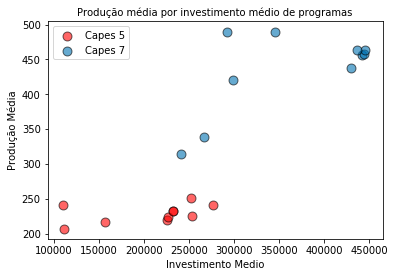

In [9]:
plt.scatter(producao_cp5['InvestimentoMedioPCurso'], producao_cp5['ProducaoMediaPorCurso'], edgecolor='k', color="red", alpha=0.6, s=80, label='Capes 5')
plt.scatter(producao_cp7['InvestimentoMedioPCurso'], producao_cp7['ProducaoMediaPorCurso'], edgecolor='k', alpha=0.6, s=80, label="Capes 7")
plt.legend()

plt.title('Produção média por investimento médio de programas')
plt.xlabel('Investimento Medio')
plt.ylabel('Produção Média')



In [10]:
#sns.pairplot(producao_cp7, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

## Regressão Linear

In [11]:
# Fazendo a regressao
X = producao_cp5[['InvestimentoMedioPCurso']]
#display(X.shape)
y = producao_cp5[['ProducaoMediaPorCurso']]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

print (X_train.shape)
print(y_train.shape)
print (X_test.shape)
print(y_test.shape)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

(8, 1)
(8, 1)
(2, 1)
(2, 1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
# Previsao
y_pred = lin_regr.predict(X_test)

# Metricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Coefficient: {0:.2f}'.format(lin_regr.coef_[0][0]))
print('Intercept: {0:.2f}'.format(lin_regr.intercept_[0]))
print('Mean squared error: {0:.2f}'.format(mse) )
print('R2: {0:.2f}'.format(r2))

Coefficient: 0.00
Intercept: 212.17
Mean squared error: 255.13
R2: 0.01


### Capes 5

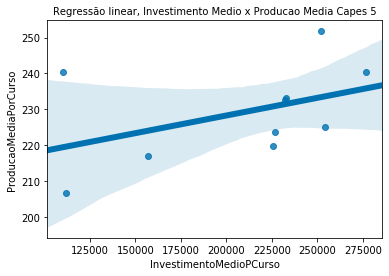

In [13]:
sns.regplot(x='InvestimentoMedioPCurso', y='ProducaoMediaPorCurso', data=producao_cp5)
plt.title('Regressão linear, Investimento Medio x Producao Media Capes 5')
plt.show()

### É possível ver que o o investimento médio e a produção média não são tão bem explicados por um modelo linear. Vamos analisar então as dissertações

In [14]:
# Fazendo a regressao
X = producao_cp7[['InvestimentoMedioPCurso']]
#display(X.shape)
y = producao_cp7[['ProducaoMediaPorCurso']]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

# Previsao
y_pred = lin_regr.predict(X_test)

# Metricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Coefficient: {0:.2f}'.format(lin_regr.coef_[0][0]))
print('Intercept: {0:.2f}'.format(lin_regr.intercept_[0]))
print('Mean squared error: {0:.2f}'.format(mse) )
print('R2: {0:.2f}'.format(r2))

Coefficient: 0.00
Intercept: 254.75
Mean squared error: 297.77
R2: 0.08


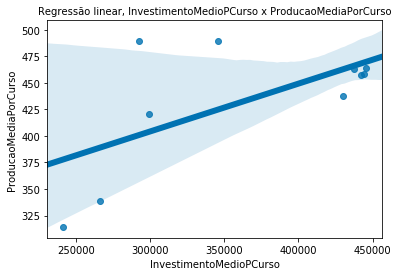

In [15]:
sns.regplot(x='InvestimentoMedioPCurso', y='ProducaoMediaPorCurso', data=producao_cp7)
plt.title('Regressão linear, InvestimentoMedioPCurso x ProducaoMediaPorCurso')
plt.show()

### A regressão consegue explicar melhor o investimento as dissertações feitas por mestrandos

Coefficient: 0.00
Intercept: 8.35
Mean squared error: 106.07
R2: 0.44


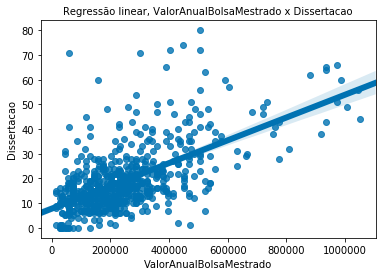

In [16]:
#"Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas"
# Fazendo a regressao
X = cursos_mestrado[['ValorAnualBolsaMestrado']]
y = cursos_mestrado[["Dissertacao"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='Dissertacao', data=cursos_mestrado)
plt.title('Regressão linear, ValorAnualBolsaMestrado x Dissertacao')
plt.show()

### As produções bibliográficas não são bem explicadas com uma regressão linear, visto o R2 baixo

Coefficient: 0.00
Intercept: 96.49
Mean squared error: 10998.67
R2: 0.12


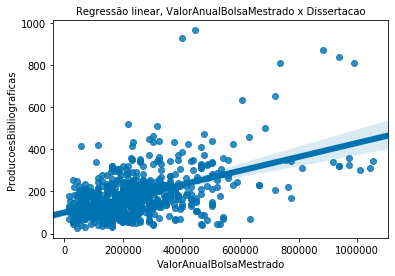

In [17]:
# Fazendo a regressao
X = cursos_mestrado[['ValorAnualBolsaMestrado']]
#display(X.shape)
y = cursos_mestrado[["ProducoesBibliograficas"]]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='ProducoesBibliograficas', data=cursos_mestrado)
plt.title('Regressão linear, ValorAnualBolsaMestrado x Dissertacao')
plt.show()

### Prever as produções tecnicas com o investimento através de uma regressão linear se mostra pior que do que prever utilizando a média 

Coefficient: 0.00
Intercept: 20.30
Mean squared error: 32308.31
R2: -0.01


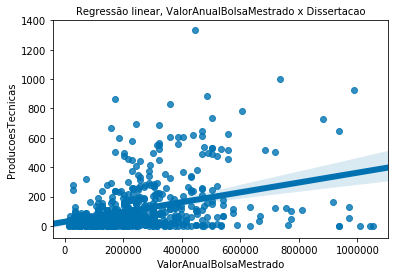

In [18]:
# Fazendo a regressao
X = cursos_mestrado[['ValorAnualBolsaMestrado']]
#display(X.shape)
y = cursos_mestrado[["ProducoesTecnicas"]]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='ProducoesTecnicas', data=cursos_mestrado)
plt.title('Regressão linear, ValorAnualBolsaMestrado x Dissertacao')
plt.show()

### Semelhantemente o investimento nas produções artísticas não são bem previstas utilizando um modelo linear

Coefficient: 0.00
Intercept: -0.61
Mean squared error: 883.52
R2: 0.01


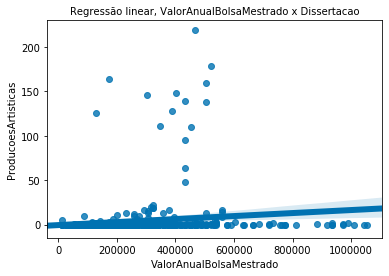

In [19]:
#"Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas"
# Fazendo a regressao
X = cursos_mestrado[['ValorAnualBolsaMestrado']]
#display(X.shape)
y = cursos_mestrado[["ProducoesArtisticas"]]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='ProducoesArtisticas', data=cursos_mestrado)
plt.title('Regressão linear, ValorAnualBolsaMestrado x Dissertacao')
plt.show()

### Já as produções bibliográficas são previstas um pouco melhor que a média


Coefficient: 0.00
Intercept: 122.29
Mean squared error: 20783.24
R2: 0.28


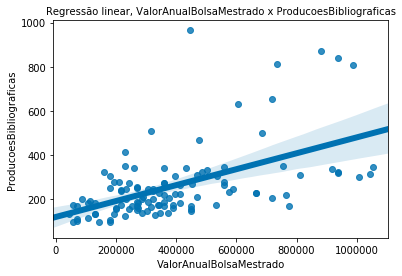

In [20]:
#"Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas"
# Fazendo a regressao
X = mestrado_capes_7[['ValorAnualBolsaMestrado']]
#display(X.shape)
y = mestrado_capes_7[["ProducoesBibliograficas"]]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='ProducoesBibliograficas', data=mestrado_capes_7)
plt.title('Regressão linear, ValorAnualBolsaMestrado x ProducoesBibliograficas')
plt.show()

### Cursos capes 7 tem uma relação mais forte entre investimento e as dissertações

Coefficient: 0.00
Intercept: 9.06
Mean squared error: 64.45
R2: 0.62


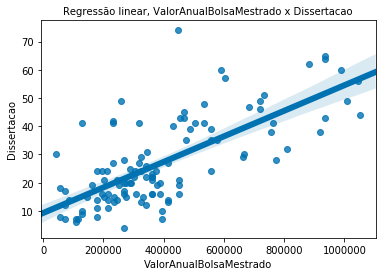

In [21]:
#"Dissertacao", "ProducoesBibliograficas", "ProducoesTecnicas", "ProducoesArtisticas"
# Fazendo a regressao
X = mestrado_capes_7[['ValorAnualBolsaMestrado']]
#display(X.shape)
y = mestrado_capes_7[["Dissertacao"]]
#display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='Dissertacao', data=mestrado_capes_7)
plt.title('Regressão linear, ValorAnualBolsaMestrado x Dissertacao')
plt.show()

## Capes 5, investimento e dissertação

### Cursos capes 5 tem uma relação mais fraca entre investimento e as dissertações

Coefficient: 0.00
Intercept: 8.14
Mean squared error: 79.53
R2: 0.28


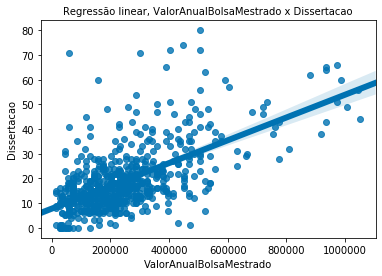

In [22]:
X = mestrado_capes_5[['ValorAnualBolsaMestrado']]
y = mestrado_capes_5[["Dissertacao"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

y_pred = lin_regr.predict(X_test)

print(f'Coefficient: {lin_regr.coef_[0][0]:.2f}')
print(f'Intercept: {lin_regr.intercept_[0]:.2f}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
sns.regplot(x='ValorAnualBolsaMestrado', y='Dissertacao', data=cursos_mestrado)
plt.title('Regressão linear, ValorAnualBolsaMestrado x Dissertacao')
plt.show()

## Regressão para os cursos de doutorado

#### As regressões para o doutorado vão ser feitas posteriormente

# Intervalo de Confiança

## Testes de Hipótese
### Teste 1
#### Hipótese nula:
Na população, a distribuição das produções é a mesma para programas com investimento maior que a média e menores que a média. A diferença na amostra é devido a chance.
#### Hipótese alternativa: 
Na população, a distribuição de produção para os programas com maior investimento que a média é maior, na média, do que dos cursos com menos investimento

In [23]:
# Vamos separar as produções por intervalo de investimento
cursos_mestrado['ProducaoTotal'] = cursos_mestrado['ProducoesTecnicas'] + cursos_mestrado['ProducoesBibliograficas'] + cursos_mestrado['ProducoesArtisticas']
investimento_mestrado = cursos_mestrado[['ValorAnualBolsaMestrado', 'ProducaoTotal']]

In [24]:
media = investimento_mestrado['ValorAnualBolsaMestrado'].mean()
# Separando os cursos em os que ganham mais e os que ganham menos
cursos_menos_valor = investimento_mestrado.query("ValorAnualBolsaMestrado < {}".format(media))
cursos_mais_valor = investimento_mestrado.query("ValorAnualBolsaMestrado > {}".format(media))

In [25]:
cursos_mais_valor.mean()

ValorAnualBolsaMestrado    401507.865169
ProducaoTotal                 408.797753
dtype: float64

In [26]:
cursos_menos_valor.mean()

ValorAnualBolsaMestrado    146216.452442
ProducaoTotal                 221.347044
dtype: float64

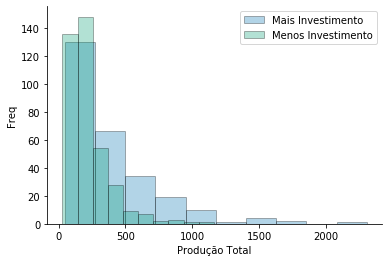

In [33]:
def bootstrap_mean(df, column, n=5000, size=None):
    '''
    Faz um boostrap da média. Gera amostras.
    
    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df[column].sample(size, replace=True)
        values[i] = sample.mean()
    return values

def ic_bootstrap(df, column, n=5000, size=None):
    '''
    Faz um IC boostrap da média. Gera um Intervalo.
    
    Parâmetros
    ----------
    df: o dataframe
    column: a coluna que queremos focar
    n: número de amostras para o bootstrap
    size: tamanho de cada amostra, por padrão vira o tamanho do df.
    '''
        
    values = bootstrap_mean(df, column, n, size)
    return (np.percentile(values, 2.5), np.percentile(values, 97.5))

def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


plt.hist(cursos_mais_valor['ProducaoTotal'], alpha=0.3, edgecolor='k', label='Mais Investimento')
plt.hist(cursos_menos_valor['ProducaoTotal'], alpha=0.3, edgecolor='k', label='Menos Investimento')
despine()

plt.xlabel('Produção Total')
plt.ylabel('Freq')
plt.legend()

In [34]:
ic_bootstrap(cursos_menos_valor, 'ProducaoTotal')


(206.00687660668382, 237.31767352185088)

In [35]:
ic_bootstrap(cursos_mais_valor, 'ProducaoTotal')


(370.2161048689138, 449.03305243445686)

,cursos_mais_valor_boot,cursos_menos_valor_boot
0,365.389513,215.323907
1,410.580524,218.084833
2,417.749064,228.925450
3,373.292135,212.172237
4,418.666667,219.979434
...,...,...
4995,426.404494,223.735219
4996,397.692884,210.814910
4997,429.269663,221.105398
4998,403.805243,215.131105


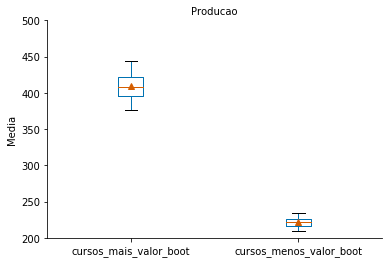

In [36]:
samples_cursos_mais_valor = bootstrap_mean(cursos_mais_valor, 'ProducaoTotal')
samples_cursos_menos_valor = bootstrap_mean(cursos_menos_valor, 'ProducaoTotal')

to_plot = pd.DataFrame()
to_plot['cursos_mais_valor_boot'] = samples_cursos_mais_valor
to_plot['cursos_menos_valor_boot'] = samples_cursos_menos_valor
display(to_plot)
to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)
plt.ylim(200, 500)
plt.ylabel('Media')
plt.title("Producao")
despine()

187.45070910718928


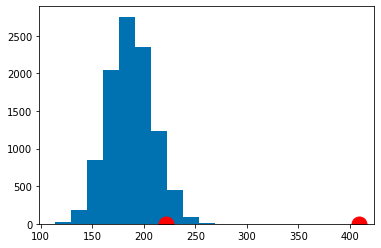

In [37]:
def resample(sample):
    return np.random.choice(sample, size=len(sample))

def bootstrap(sample, stat, replicates):
    return np.array([
        stat(resample(sample)) for _ in range(replicates)
    ])

observed_difference = np.mean(cursos_mais_valor['ProducaoTotal']) - np.mean(cursos_menos_valor['ProducaoTotal'])
print(observed_difference)

## Bootstrap da media da producao total
cursos_menos_valor_media = bootstrap(cursos_menos_valor['ProducaoTotal'], np.mean, 10000)
cursos_mais_valor_media = bootstrap(cursos_mais_valor['ProducaoTotal'], np.mean, 10000)

mean_differences = cursos_mais_valor_media - cursos_menos_valor_media
plt.hist(mean_differences)
plt.plot(cursos_menos_valor['ProducaoTotal'].mean(), [1], 'ro', ms=15)
plt.plot(cursos_mais_valor['ProducaoTotal'].mean(), [0], 'ro', ms=15)

In [38]:
(np.percentile(mean_differences, 2.5), 
 np.percentile(mean_differences, 97.5))

(146.16942101614626, 230.5742273475636)

A produção dos cursos com mais investimento não está no intervalo de confiança da média da produção total de 95%. Logo pode-se rejeitar a hipótese nula.

## Teste de hipótese 2

### Teste 2
#### Hipótese nula:
Na população, a distribuição do investimento é a mesma para programas com notas capes altas (maiores ou iguais a 6) e para menores ou iguais a 5. A diferença na amostra é devido a chance.
#### Hipótese alternativa: 
Na população, a distribuição do investimento para programas com notas capes altas (maiores ou iguais a 6) é maior, na média,  do que para cursos com notas menores ou iguais a 5.

In [39]:
# Separando os cursos em os que ganham mais e os que ganham menos
cursos_nota_capes_baixa = cursos_mestrado.query("NotaCapesMestrado <= 5")[['NotaCapesMestrado', 'ValorAnualBolsaMestrado']]
cursos_nota_capes_alta = cursos_mestrado.query("NotaCapesMestrado >= 6")[['NotaCapesMestrado', 'ValorAnualBolsaMestrado']]

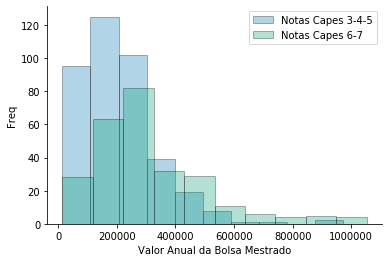

In [40]:
plt.hist(cursos_nota_capes_baixa['ValorAnualBolsaMestrado'], alpha=0.3, edgecolor='k', label='Notas Capes 3-4-5')
plt.hist(cursos_nota_capes_alta['ValorAnualBolsaMestrado'], alpha=0.3, edgecolor='k', label='Notas Capes 6-7')
despine()

plt.xlabel('Valor Anual da Bolsa Mestrado')
plt.ylabel('Freq')
plt.legend()

In [41]:
ic_bootstrap(cursos_nota_capes_baixa, 'ValorAnualBolsaMestrado')


(191667.85714285713, 218016.9642857143)

In [42]:
ic_bootstrap(cursos_nota_capes_alta, 'ValorAnualBolsaMestrado')


(294145.0568181818, 341706.98863636365)

,cursos_mais_valor_boot,cursos_menos_valor_boot
0,332577.272727,201443.877551
1,309627.272727,210549.489796
2,312286.363636,201150.000000
3,350331.818182,192673.469388
4,305495.454545,209199.489796
...,...,...
4995,311052.272727,198964.285714
4996,312334.090909,204621.428571
4997,314025.000000,205659.183673
4998,311263.636364,197403.061224


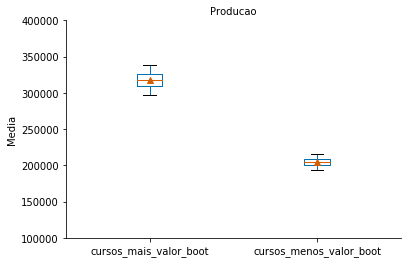

In [43]:
samples_cursos_nota_cp_alta = bootstrap_mean(cursos_nota_capes_alta, 'ValorAnualBolsaMestrado')
samples_cursos_nota_cp_baixa = bootstrap_mean(cursos_nota_capes_baixa, 'ValorAnualBolsaMestrado')

to_plot = pd.DataFrame()
to_plot['cursos_mais_valor_boot'] = samples_cursos_nota_cp_alta
to_plot['cursos_menos_valor_boot'] = samples_cursos_nota_cp_baixa
display(to_plot)
to_plot.boxplot(grid=False, sym='', whis=[5, 95], showmeans=True)
plt.ylim(100000, 400000)
plt.ylabel('Media')
plt.title("Producao")
despine()

112882.37476808904


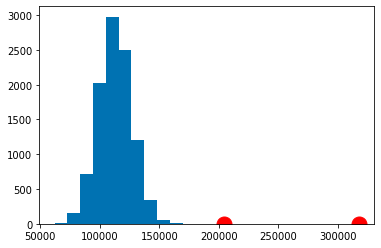

In [44]:
observed_difference = np.mean(cursos_nota_capes_alta['ValorAnualBolsaMestrado']) - np.mean(cursos_nota_capes_baixa['ValorAnualBolsaMestrado'])
print(observed_difference)

## Bootstrap da media da producao total
cursos_nota_capes_baixa_media = bootstrap(cursos_nota_capes_baixa['ValorAnualBolsaMestrado'], np.mean, 10000)
cursos_nota_capes_alta_media = bootstrap(cursos_nota_capes_alta['ValorAnualBolsaMestrado'], np.mean, 10000)

mean_differences = cursos_nota_capes_alta_media - cursos_nota_capes_baixa_media
plt.hist(mean_differences)
plt.plot(cursos_nota_capes_baixa['ValorAnualBolsaMestrado'].mean(), [1], 'ro', ms=15)
plt.plot(cursos_nota_capes_alta['ValorAnualBolsaMestrado'].mean(), [0], 'ro', ms=15)

Com isso podemos rejeitar a hipótese nula de que na população, a distribuição do investimento é a mesma para programas com notas capes altas (maiores ou iguais a 6) e para menores ou iguais a 5. A diferença na amostra é devido a chance.